# Exploratory data analysis for time series

1. Descriptive statistics
2. Descriptive statistics over sliding windows
3. Temporal correlations (auto-correlation, cross-correlation)
3. Scatter plots with possible differencing to mitigate temporal dependencies, connecting scatter plots in order
4. Seasonal decomposition
5. Binning/features extraction combined with standard cross-sectional exploratory data analysis
6. Simple models (naïve baselines, common baseline models), specific to learning task

In [1]:
from utils import load_temperature
from utils import load_pressure

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Single series

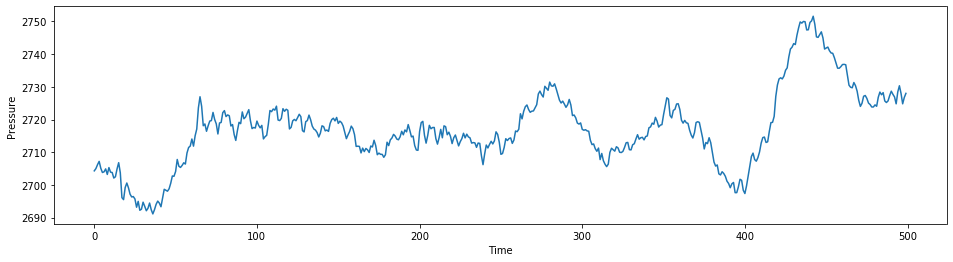

In [2]:
pressure = load_pressure()
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
pressure.plot(ax=ax)
ax.set(ylabel="Pressure", xlabel="Time");

### Descriptive statistics
* Basic descriptive stats, but note that common uncertainty quantifications like confidence intervals and standard errors have to be interpreted carefully as samples are not i.i.d.

In [3]:
pressure.describe()

count     500.00000
mean     2717.10828
std        11.41151
min      2691.12500
25%      2711.27000
50%      2716.51000
75%      2722.77250
max      2751.60500
Name: pressure, dtype: float64

#### Many more time series specific statistics: 
* https://www.statsmodels.org/stable/tsa.html
* https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html

### Descriptive statistics with rolling window
* uses past and present data to compute descriptive statistics, so not suitable for online learning setting (e.g. anomaly detection in real time)

#### Rolling mean

In [4]:
window_length = 10  # typically set to the seasonal periodicity, i.e. the period per year, e.g. 12 for monthly data

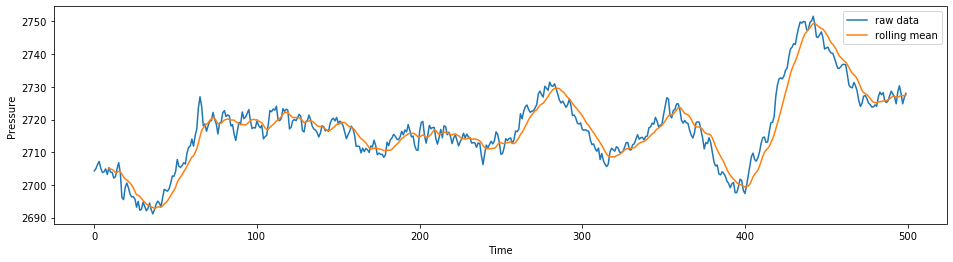

In [5]:
pressure = load_pressure()
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
pressure.plot(ax=ax, label="raw data")
yt = pressure.rolling(window_length).mean()
yt.plot(ax=ax, label="rolling mean")
ax.set(ylabel="Pressure", xlabel="Time")
plt.legend();

#### Rolling mean with rolling standard deviation

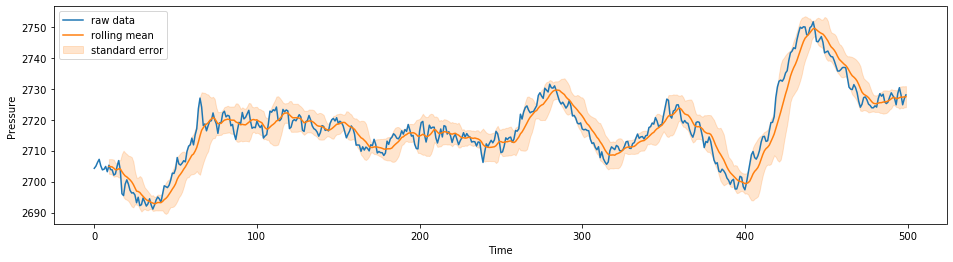

In [6]:
pressure = load_pressure()
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
pressure.plot(ax=ax, label="raw data")
yt = pressure.rolling(window_length).mean()
yt.plot(ax=ax, label="rolling mean");
rolling_std = pressure.rolling(window_length).std()
ax.fill_between(pressure.index, yt + (2 * rolling_std), yt - (2 * rolling_std), alpha=0.2, color=u'#ff7f0e', label="standard error")
ax.set(ylabel="Pressure", xlabel="Time")
plt.legend();

#### Rolling quantiles

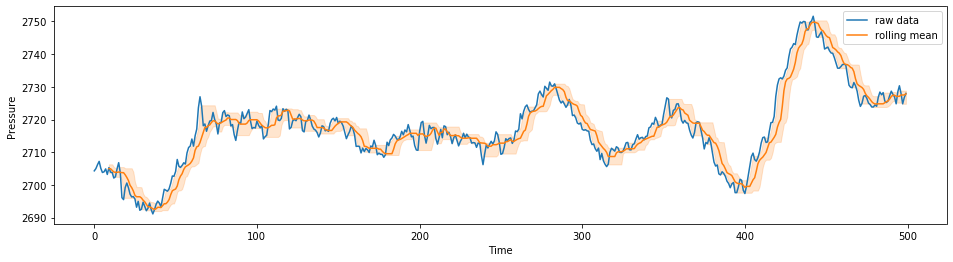

In [7]:
pressure = load_pressure()
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
pressure.plot(ax=ax, label="raw data")
q1 = pressure.rolling(window_length).quantile(.1)
median = pressure.rolling(window_length).quantile(.5)
q3 = pressure.rolling(window_length).quantile(.9)
median.plot(ax=ax, label="rolling mean");
rolling_std = pressure.rolling(window_length).std()
ax.fill_between(pressure.index, q1, q3, alpha=0.2, color=u'#ff7f0e')
ax.set(ylabel="Pressure", xlabel="Time")
plt.legend();

#### Exponential weighted mean

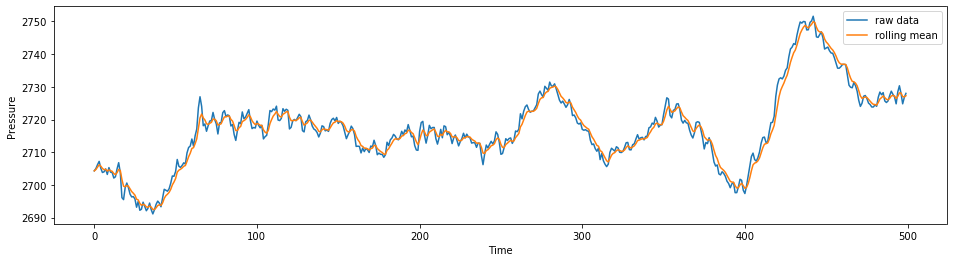

In [8]:
pressure = load_pressure()
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
pressure.plot(ax=ax, label="raw data")
pressure.ewm(span=5).mean().plot(ax=ax, label="rolling mean")
ax.set(ylabel="Pressure", xlabel="Time")
plt.legend();

### Autocorrelation

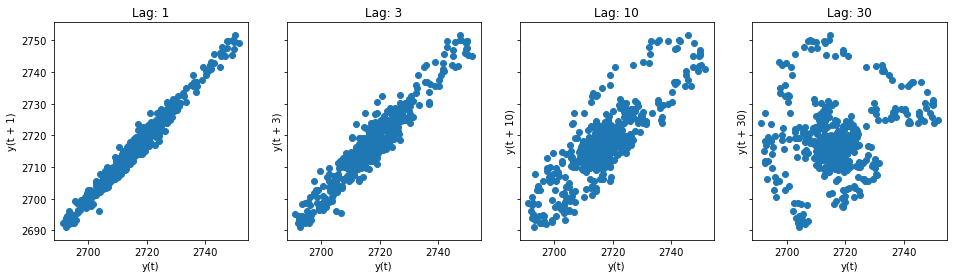

In [9]:
from pandas.plotting import lag_plot
lags = [1, 3, 10, 30]
fig, axs = plt.subplots(ncols=4, figsize=plt.figaspect(.25), sharey=True)
for k, lag in enumerate(lags):
    ax = axs[k]
    lag_plot(pressure, lag=lag, ax=ax)
    ax.set_title(f"Lag: {lag}")

In [10]:
# manual calculation
def compute_autocorr(x, lags=None):
    """
    Estimate autocorrelation for time series x and given lags
    
    References
    ----------
    ..[1] Time-Series Analysis: Forecasting and Control, 4th ed. (Box, Jenkins, Reinsel), p. 31
    """
    
    x = np.asarray(x) 
    n_timepoints = x.shape[0]
    
    mu = x.mean()
    c_0 = np.var(x)  # np.std(x) * np.std(x)
    
    def corrcoef(k):
        """
        Estimate autocorrelation at lag k (sample autocorrelation function).
        """
        return np.sum((x[:-k] - mu) * (x[k:] - mu)) / n_timepoints / c_0
    
    lags = np.arange(1, n_timepoints)
    
    return np.array([1] + [corrcoef(lag) for lag in lags])

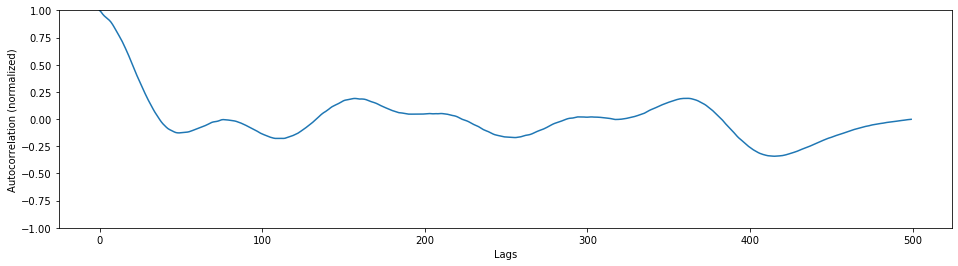

In [11]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
rho = compute_autocorr(pressure)
ax.plot(rho)
ax.set(ylim=(-1, 1), xlabel="Lags", ylabel="Autocorrelation (normalized)");

In [12]:
# using statsmodels
from statsmodels.tsa.stattools import acf
rho_statsmodels = acf(pressure, nlags=len(pressure), fft=False)
np.testing.assert_almost_equal(rho, rho_statsmodels)

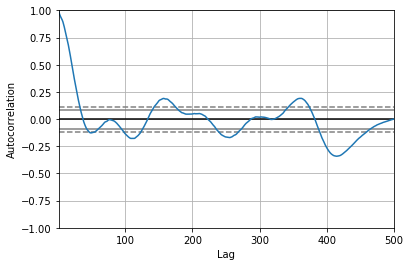

In [13]:
# using pandas
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(pressure);

In [14]:
# using numpy
# def compute_autocorr_with_np(x, lags=None):
#     x = np.asarray(x)
#     n_timepoints = x.shape[0]

#     if lags is None:
#         lags = np.arange(n_timepoints) + 1

#     return np.array([np.corrcoef(x[lag:], x[:-lag])[0, 1] for lag in lags])

### Partial autocorrelation

The partial autocorrelation at lag *k* is the partial correlation between the variables $z_t$ and $z_{t-k}$ adjusted for the intermediate variables $z_{t-1}, z_{t-2} ... z_{t-k+1}$. In other words, the correlation between $z_t$ and $z_{t-k}$ not accounted for by $z_{t-1}, z_{t-2} ... z_{t-k+1}$. 

* [Partial correlation](https://en.wikipedia.org/wiki/Partial_correlation) 

In [15]:
# using statsmodels
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
pacf(pressure, nlags=10)

array([ 1.        ,  0.98626245, -0.17510467,  0.16772035,  0.06404346,
        0.00938107, -0.04624548, -0.09897693, -0.18668618, -0.1094158 ,
       -0.15396139])

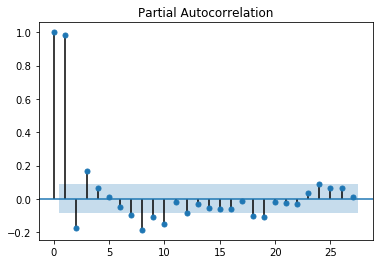

In [16]:
plot_pacf(pressure);

### Time series decomposition: trends & seasonality

#### Classical decomposition
For other decompositons, see https://otexts.com/fpp3/decomposition.html

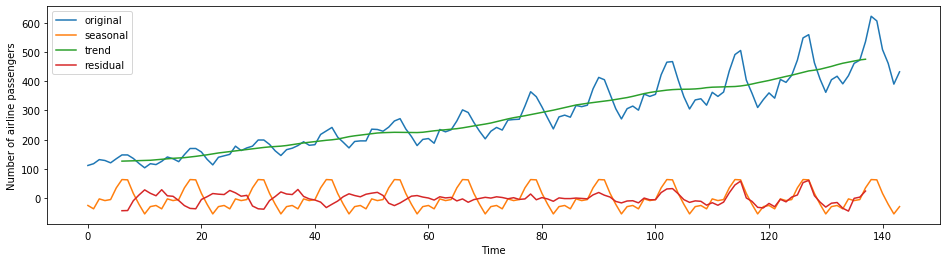

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.datasets import load_airline

y = load_airline()  # monthly data
sp = 12  # seasonal periodicity, or periods per year

decomposition = seasonal_decompose(y, model="additive", period=sp)

fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
y.plot(ax=ax, label="original")
decomposition.seasonal.plot(ax=ax, label="seasonal")
decomposition.trend.plot(ax=ax, label="trend")
decomposition.resid.plot(ax=ax, label="residual")
ax.set(xlabel="Time", ylabel="Number of airline passengers")
plt.legend();

#### Seasonality

For more plots, see https://otexts.com/fpp2/seasonal-plots.html

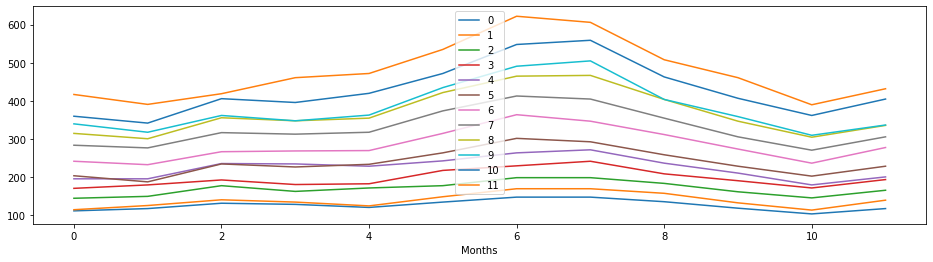

In [18]:
seasons = np.arange(0, len(y), sp)
x = np.zeros((len(seasons), sp))
for i, season in enumerate(seasons):
    x[i, :] = y.iloc[season:season + sp]

fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
pd.DataFrame(x.T).plot(ax=ax)
ax.set(xlabel="Months");

### Hypothesis testing

Hypothesis testing on 
* Seasonality
* Stationary (unit root tests)
* Correlation (e.g. Box-Pierce test, Ljung-Box)

But beware of the multiple testing problem. Use portmanteau tests if possible (see https://otexts.com/fpp2/residuals.html). 

Hypothesis tests can also be used as heuristics for making/automating modelling choices (e.g. AutoARIMA).  

## Multivariate time series

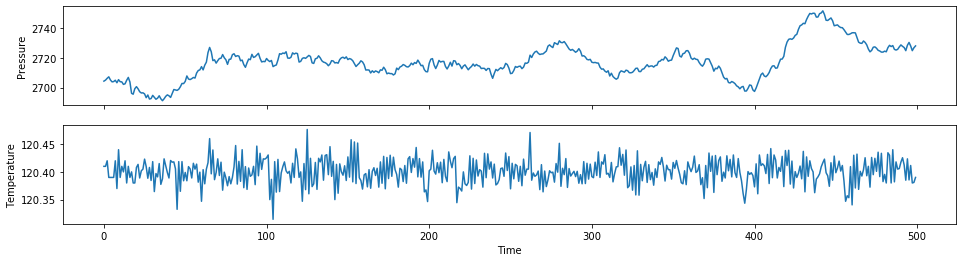

In [19]:
temperature = load_temperature()
fig, axs = plt.subplots(nrows=2, figsize=plt.figaspect(.25), sharex=True)
pressure.plot(ax=axs[0])
axs[0].set(ylabel="Pressure", xlabel="Time");
temperature.plot(ax=axs[1])
axs[1].set(ylabel="Temperature", xlabel="Time");

### Scatter plots
* contemporaneous correlation

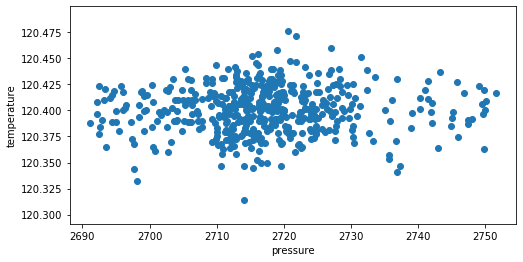

In [20]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.5))
ax.scatter(pressure, temperature)
ax.set(xlabel="pressure", ylabel="temperature");

### Cross-correlation
* correlation between two different variables and their lagged values
* not symmetric

<img src="../images/temporal_correlation.png" width=360/>

In [21]:
# manual calculation
def compute_crosscorr(x, y):
    """
    Estimate cross-correlation for time series x and given lags
    
    References
    ----------
    ..[1] Time-Series Analysis: Forecasting and Control, 4th ed. (Box, Jenkins, Reinsel), p. 432
    """
    
    x = np.asarray(x) 
    y = np.asarray(y) 
    
    assert x.shape[0] == y.shape[0]
    n_timepoints = x.shape[0]
    
    mu_x = x.mean()
    mu_y = y.mean()
    c_0 = np.std(x) * np.std(y)
    
    def corrcoef(k):
        """
        Estimate cross-correlation at lag k (sample cross-correlation function).
        """
        return np.sum((y[:-k] - mu_y) * (x[k:] - mu_x)) / n_timepoints / c_0 
    
    lags = np.arange(1, n_timepoints)
    
    r_1 = np.corrcoef(temperature, pressure)[0, 1]
    return np.array([r_1] + [corrcoef(lag) for lag in lags])

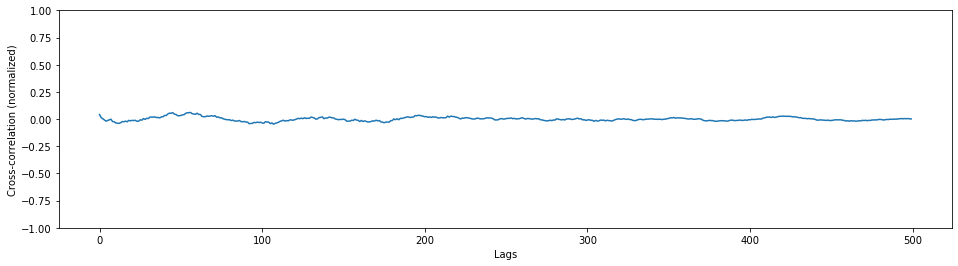

In [22]:
r = compute_crosscorr(temperature, pressure)
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
ax.plot(r)
ax.set(ylim=(-1, 1), xlabel="Lags", ylabel="Cross-correlation (normalized)");

In [23]:
# using statsmodels
from statsmodels.tsa.stattools import ccf
r_statsmodels = ccf(temperature, pressure, unbiased=False)
np.testing.assert_array_almost_equal(r, r_statsmodels)

## Panel data: reduction to tabular exploratory data analysis via binning/feature extraction

In [24]:
from utils import load_experiments
panel = load_experiments()

panel.head()

pressure                                                          \
time          1       2       3       4       5       6       7       8   
run_id                                                                    
1        2704.3  2705.0  2706.2  2707.2  2705.1  2703.8  2704.0  2704.9   
2        2706.4  2706.0  2704.9  2705.6  2705.4  2705.2  2706.5  2708.8   
3        2705.5  2704.5  2707.0  2706.7  2704.8  2701.9  2703.7  2704.6   
4        2705.3  2704.8  2704.4  2703.6  2705.1  2708.5  2705.6  2703.9   
5        2704.8  2704.4  2706.1  2706.1  2705.4  2706.1  2705.7  2705.5   

                        ... temperature                                \
time         9      10  ...         491       492       493       494   
run_id                  ...                                             
1       2703.2  2705.3  ...    120.4175  120.4255  120.4125  120.3850   
2       2707.6  2707.8  ...    120.4290  120.4030  120.4165  120.4255   
3       2706.7  2706.8  ...    120.4070  120.3855  120.4070  120.3800   
4       2698.8  2698.5  ...    120.4155  120.4050  120.4390  120.4065   
5       2702.2  2702.0  ...    120.4275  120.3785  120.4225  120.4235   

                                                                    
time         495       496       497       498       499       500  
run_id                                                              
1       120.4235  120.3855  120.4115  120.3800  120.3810  120.3900  
2       120.3840  120.4110  120.3775  120.4340  120.3705  120.4210  
3       120.4195  120.4065  120.4035  120.4155  120.4145  120.3950  
4       120.4380  120.3780  120.4290  120.3775  120.4335  120.4125  
5       120.4110  120.3815  120.4125  120.3885  120.3810  120.4155  

[5 rows x 1000 columns]

In [25]:
panel.shape

(99, 1000)

### Feature extraction
* Numerous ways to bin time series/extract features, see univariate classification notebook for more details
* Local/global, one/multi-dimensional, series-to-primitives/series

In [26]:
from tsfresh.feature_extraction.extraction import extract_features
from tsfresh.feature_extraction.settings import EfficientFCParameters, MinimalFCParameters

In [27]:
long = panel.reset_index().melt(id_vars="run_id").rename(columns={None: "variables"})

In [28]:
features = extract_features(long, default_fc_parameters=MinimalFCParameters(), 
                            column_id="run_id", column_kind="variables", column_sort="time", column_value="value")

Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 755.51it/s]


In [29]:
features.head()

variable,pressure__length,pressure__maximum,pressure__mean,pressure__median,pressure__minimum,pressure__standard_deviation,pressure__sum_values,pressure__variance,temperature__length,temperature__maximum,temperature__mean,temperature__median,temperature__minimum,temperature__standard_deviation,temperature__sum_values,temperature__variance
id,,,,,,,,,,,,,,,,
1,500.0,2751.605,2717.10828,2716.5100,2691.125,11.400093,1358554.14,129.962111,500.0,120.4765,120.400601,120.40075,120.3145,0.022802,60200.3005,0.000520
2,500.0,2738.630,2716.50218,2717.5875,2694.780,9.630455,1358251.09,92.745662,500.0,120.4705,120.401228,120.40175,120.3325,0.023508,60200.6140,0.000553
3,500.0,2751.190,2720.09130,2719.3100,2696.090,13.465389,1360045.65,181.316699,500.0,120.4625,120.400959,120.40125,120.3390,0.021435,60200.4795,0.000459
4,500.0,2762.435,2724.12364,2724.9850,2698.500,13.332113,1362061.82,177.745237,500.0,120.4615,120.400085,120.40000,120.3255,0.022643,60200.0425,0.000513
5,500.0,2743.435,2718.30680,2717.9075,2691.295,10.478888,1359153.40,109.807095,500.0,120.4620,120.398395,120.39750,120.3290,0.023149,60199.1975,0.000536


#### Tabular exploratory data analysis
Apply standard tabular exploratory analysis to extracted features:

**Inspection of single variables**
* Summary statistics
* Box plots, histograms, density plots, count plots for categorical variables

**Bi- and multivariate inspection**
* Contingency tables
* Scatter plots for pairs of variables
* Group-stratified plots

**Quantification**
* Measures of association: covariance, correlation
* Hypothesis tests whether differences are significant (t-test, Wilcoxon signed rank test, etc)

#### Correlation between variables across time points over i.i.d. instances

In [30]:
X = panel.loc[:, "pressure"].to_numpy()
y = np.random.normal(size=X.shape[0])  # fake target variable
X.shape

(99, 500)

In [31]:
from scipy.stats import pearsonr

corr = np.zeros(X.shape[1])
for timepoint in np.arange(X.shape[1]):
    corr[timepoint] = pearsonr(X[:, timepoint], y)[0]

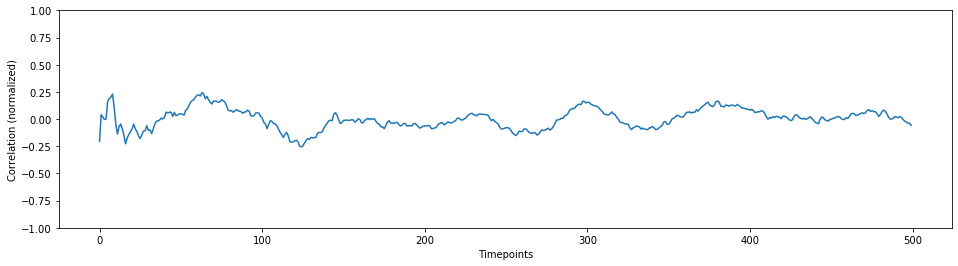

In [32]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
ax.plot(corr)
ax.set(ylim=(-1, 1), xlabel="Timepoints", ylabel="Correlation (normalized)");